## FDW Crop Production Data Profiling - Syria

In [29]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [30]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32642' # Afghanistan
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/SY_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'

parameters = {
    'format': 'json',
    'country': 'Syrian Arab Republic',
    'product': ['R011','R012','R013','R014','R015','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint,  params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df['fnid']=df['fnid'].str.replace('1982','2018')
df['fnid']=df['fnid'].str.replace('2002','2018')
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 2018	 | SY2018A1 | 14	| SY2018A2	| 62	| nan	| 0	|
----------------------------------------------- #


In [31]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'


# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Harvested')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([
    SY_Admin1_2018
], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 18,705
Removed 95 "Missing Value" points
6,233/6,235 "Area Planted" points are retained.
6,190/6,235 "Quantity Produced" points are retained.
6,187/6,235 "Yield" points are retained.
Current data points: 18,610

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1991 - 2016
28 grain types are found: Barley (Unspecified), Beans (mixed), Broad Beans, Cabbage (Unspecified), Cantaloupe, Carrots, Cauliflowers, Cucumber, Eggplant, Green bean (fresh), Groundnuts (In Shell), Lentils, Lettuce (Unspecified), Maize (Corn), Melon (unspecified), Oats (Unspecified), Okras (Fresh), Potato (unspecified), Sesame Seed, Sorghum, Soybean (unspecified), Spinach, Squash (Unspecified), Sugar beet, Swiss Chard, Tomato, Watermelon, Wheat Grain
6 seasons are found: Annual (12-01), Summer (08-01), Spring (05-01), Autumn (11-01), Winter/Autumn (09-01), Winter (12-01)
2 crop produc

- Afghanistan crop seasonal calendar

![FEWS NET](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-afghanistan.png?itok=syYg1jn1)

https://www.fao.org/giews/countrybrief/country/SYR/graphics/1_2024-11-01.jpg

![USDA](https://ipad.fas.usda.gov/countrysummary/images/AF/cropcalendar/stans_af_calendar.png)

<!-- <img src="https://www.arcgis.com/sharing/rest/content/items/2a8849d953b5405daadd2a56e5d3c64d/data"  width="60%"> -->

- FDW data consists of `AF2005A1` and `AF2017A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 2000	 | AF2000A1 | 32	| AF2000A2	| 330	|
| 2005	 | AF2005A1 | 34	| - | 0	| nan	|
| 2013	 | AF2013A1 | 34	| AF2013A2	| 399	|
| 2017	 | **`AF2017A1`** | 34	| AF2017A2	| 401	|

- Comparison between admin boundaries.

![image](https://github.com/chc-ucsb/gscd/blob/main/figures/AF_admin_shapes.png?raw=true)

- **`AF2017A1`** is used to represent current admin-level 1 crop data.
- Afghanistan has 3 crop seasons: `Spring (07-01)`, `Summer (08-01)` and `Winter (11-01)`.
- Afghanistan has no crop production system.
- Afghanistan has no population group.

In [32]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = SY_Admin1_2018.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

SY2018A101:	"Al-Hassake" (FDW) is changed to "Al-Hasakeh" (shapefile).
SY2018A103:	"Ar Raqqah" (FDW) is changed to "Ar-Raqqa" (shapefile).
SY2018A104:	"As-Suwayda" (FDW) is changed to "As-Sweida" (shapefile).
SY2018A105:	"Damascus City" (FDW) is changed to "Damascus" (shapefile).
SY2018A107:	"Dayr az Zawr" (FDW) is changed to "Deir-ez-Zor" (shapefile).
SY2018A111:	"Latakia" (FDW) is changed to "Lattakia" (shapefile).


In [33]:
# Link admin boundaries ------------------------- #
link_2018, over_2018 = FDW_PD_CreateAdminLink(SY_Admin1_2018, SY_Admin1_2018, 'ADMIN1', 'ADMIN1', prod, epsg)

# Crop specific ratios
link_ratio = FDW_PD_RatioAdminLink(link_2018, prod, over_2018, mdx_pss)

# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=False)
# ----------------------------------------------- #

In [34]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
# stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_SY.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_SY_ratio.npz', link_ratio)

../data/crop/adm_crop_production_SY.csv is saved.
../data/crop/adm_crop_production_SY_ratio.npz is saved.


## Visualization of production data

E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


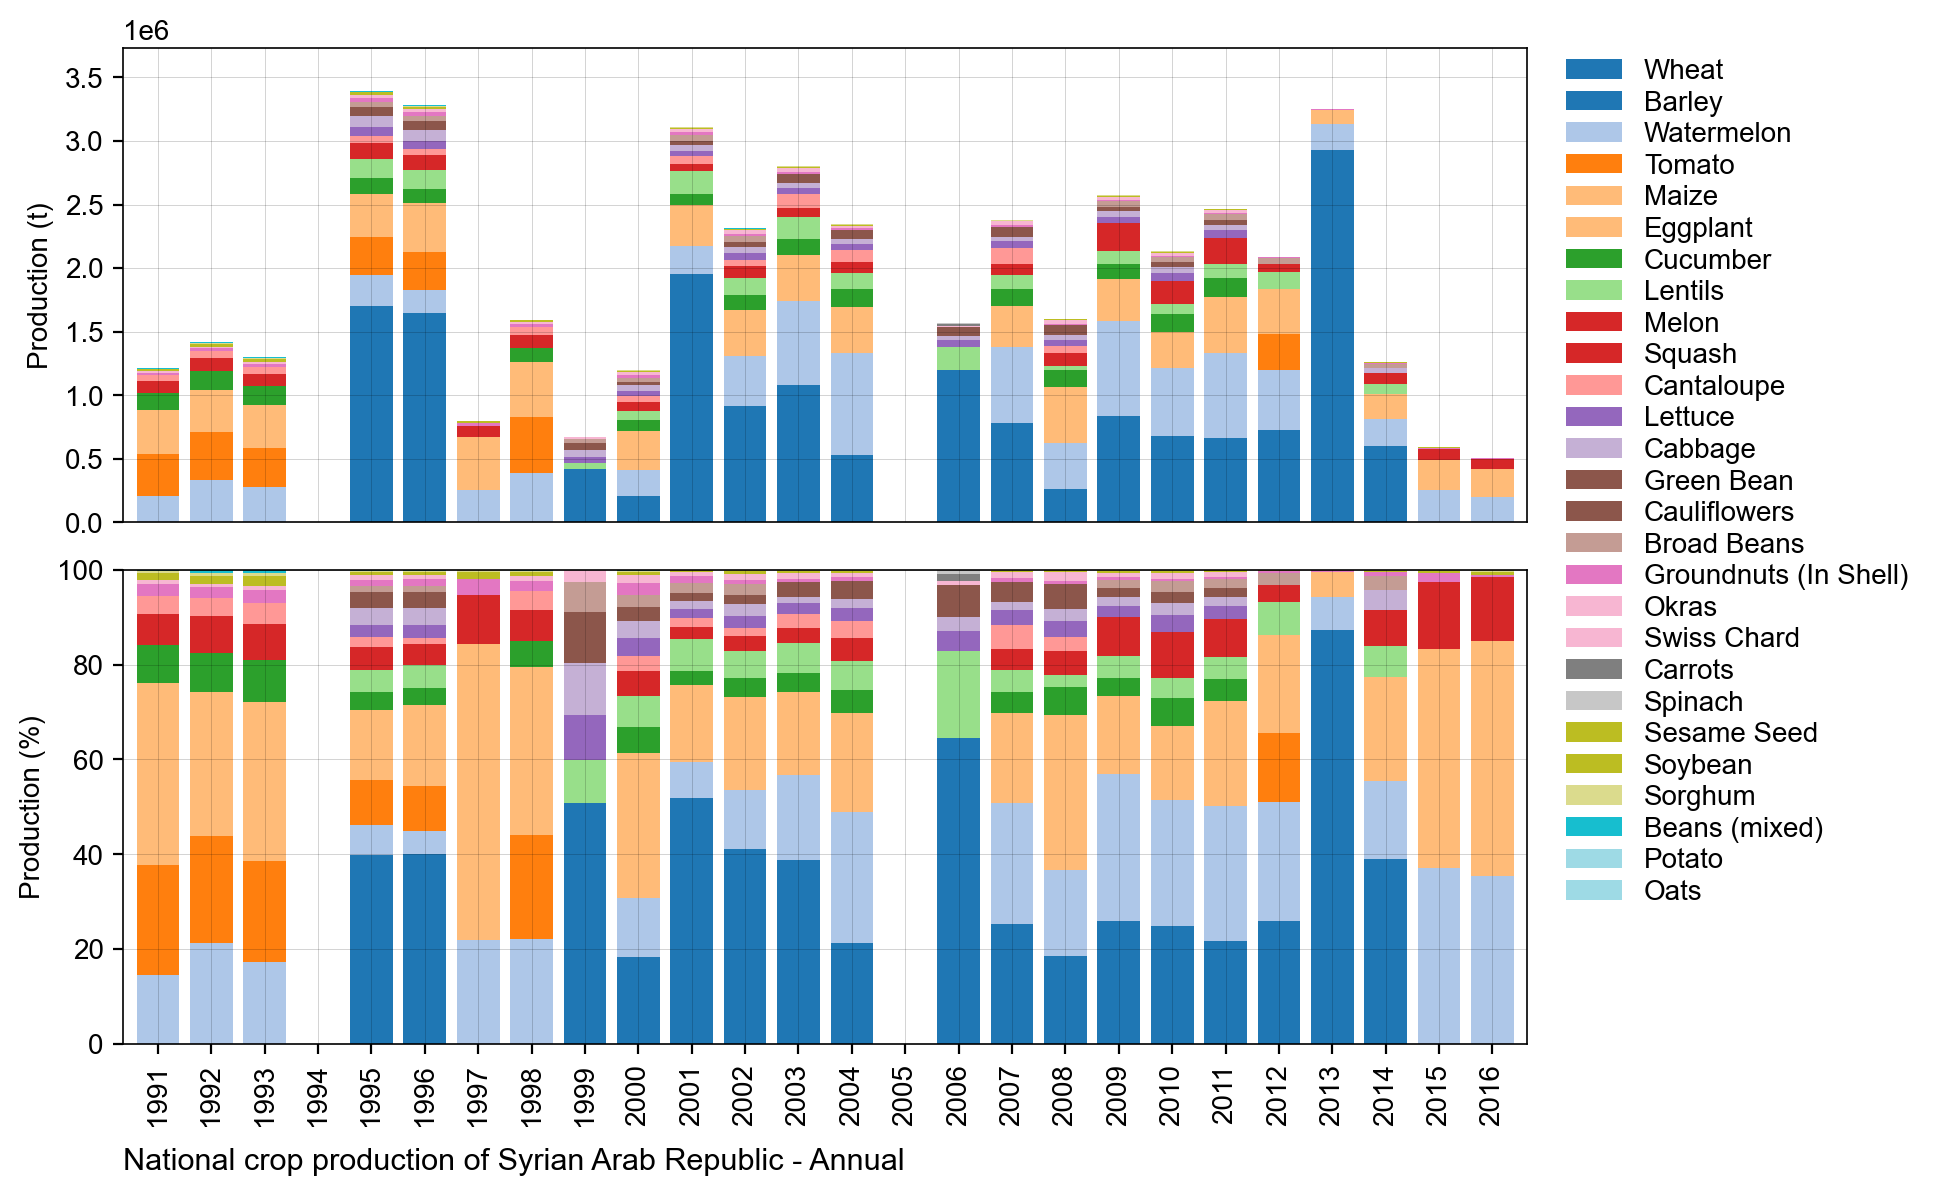

../figures/SY_bar_natgrainprod_Annual.png is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


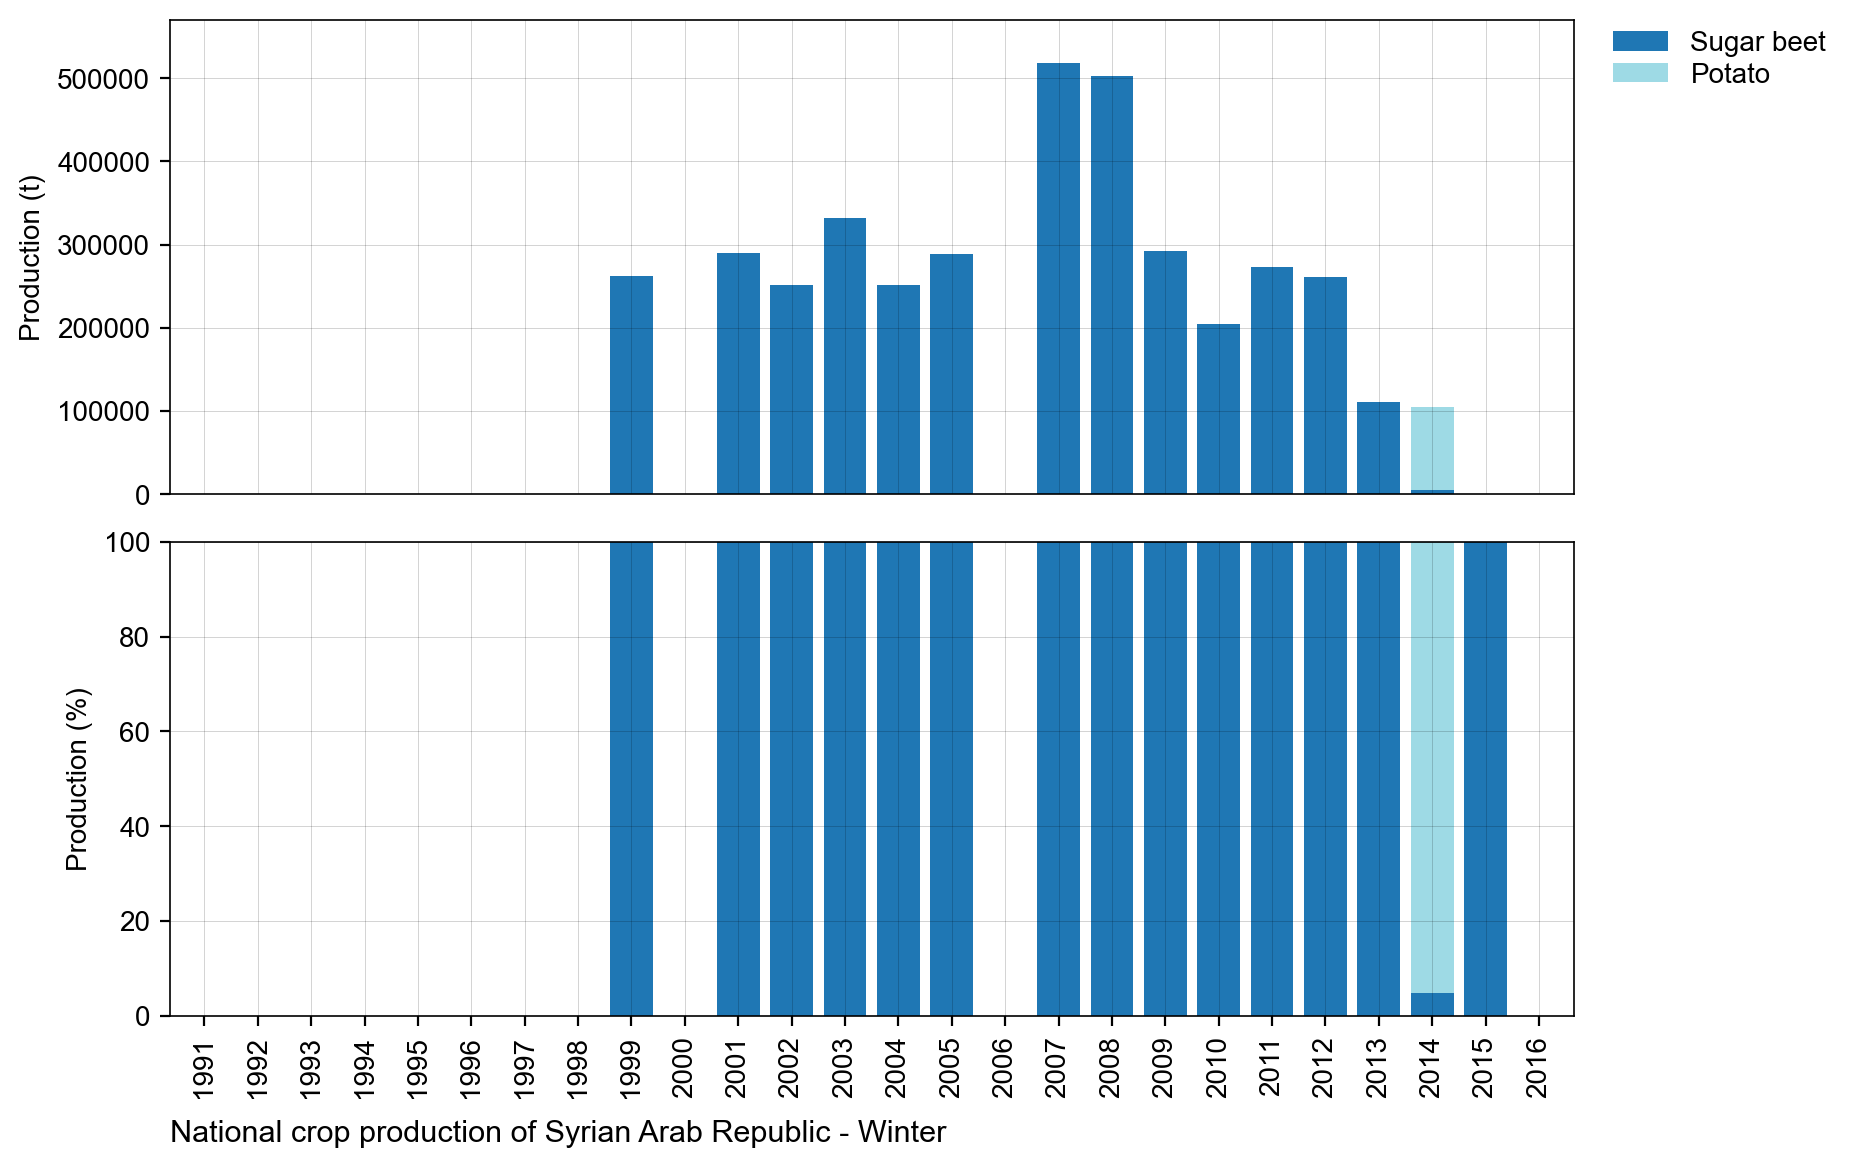

../figures/SY_bar_natgrainprod_Winter.png is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


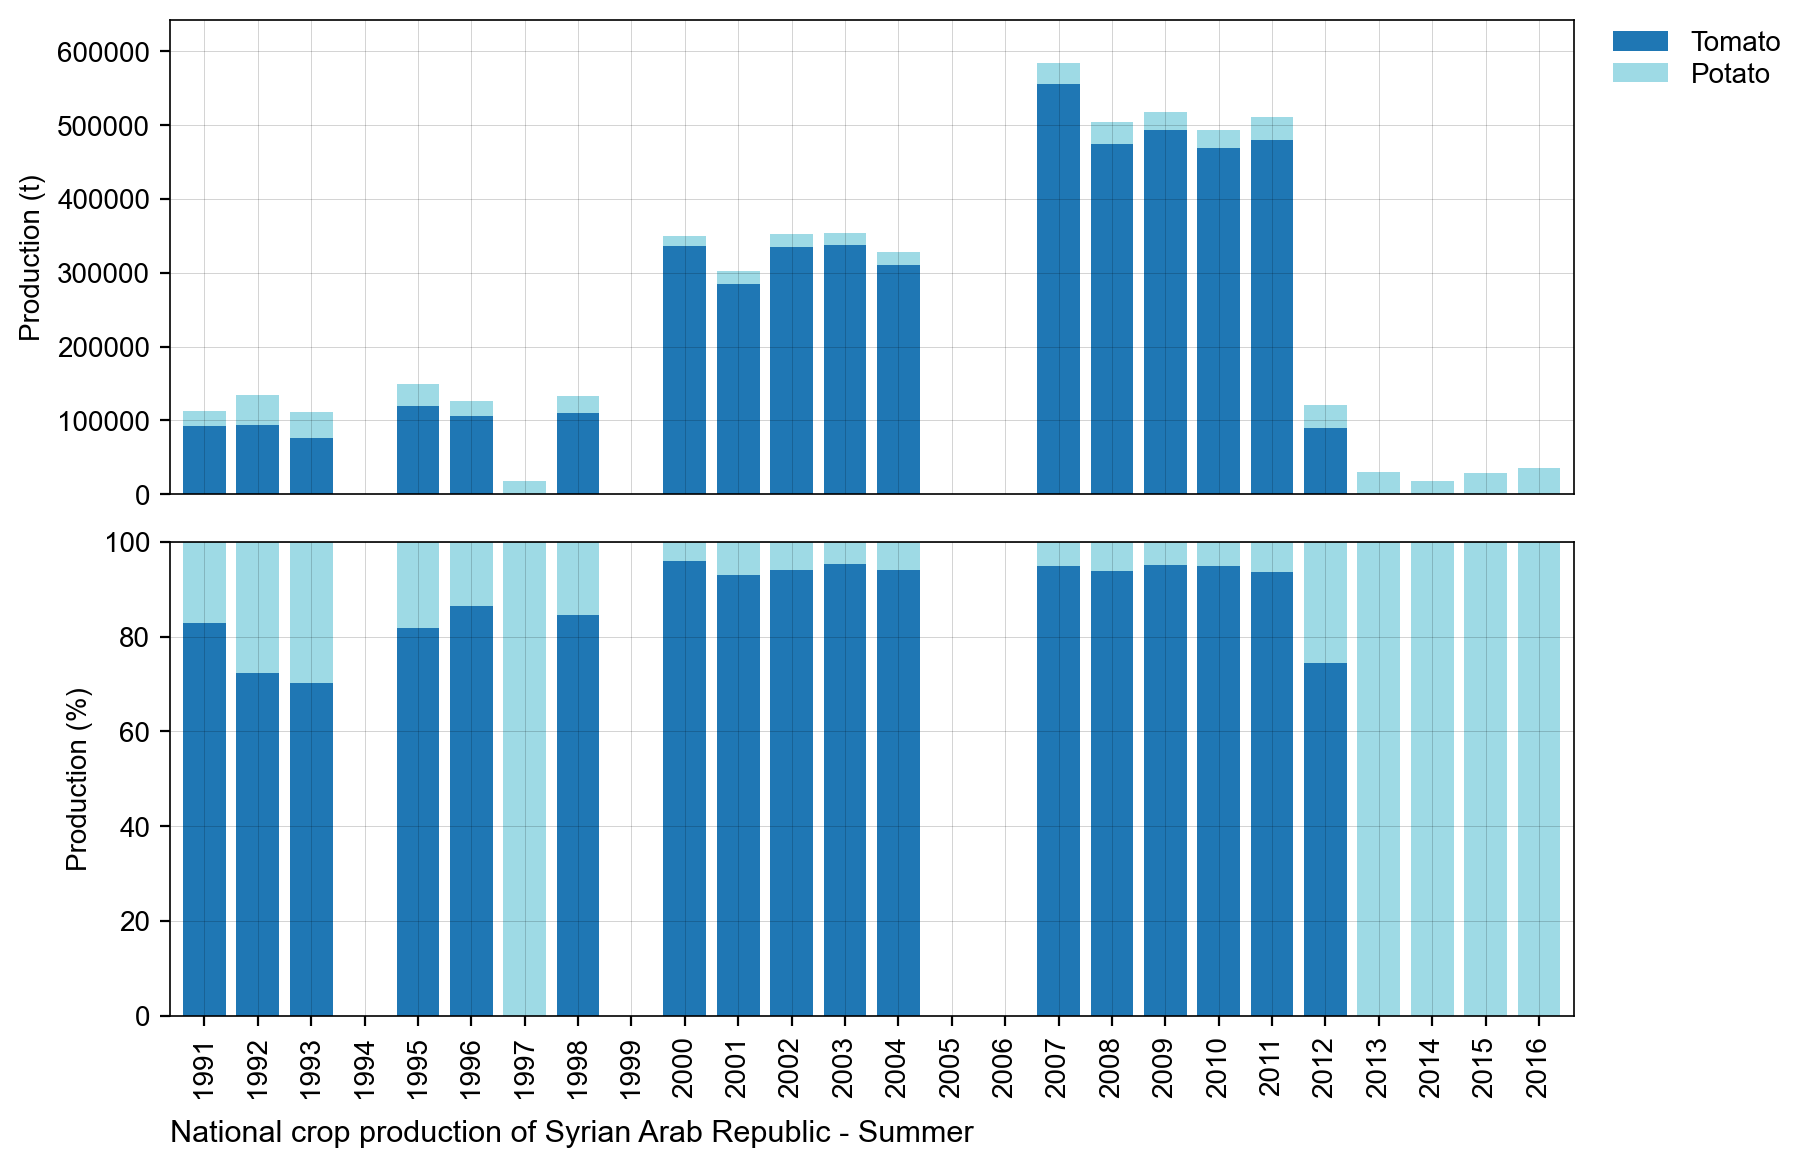

../figures/SY_bar_natgrainprod_Summer.png is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


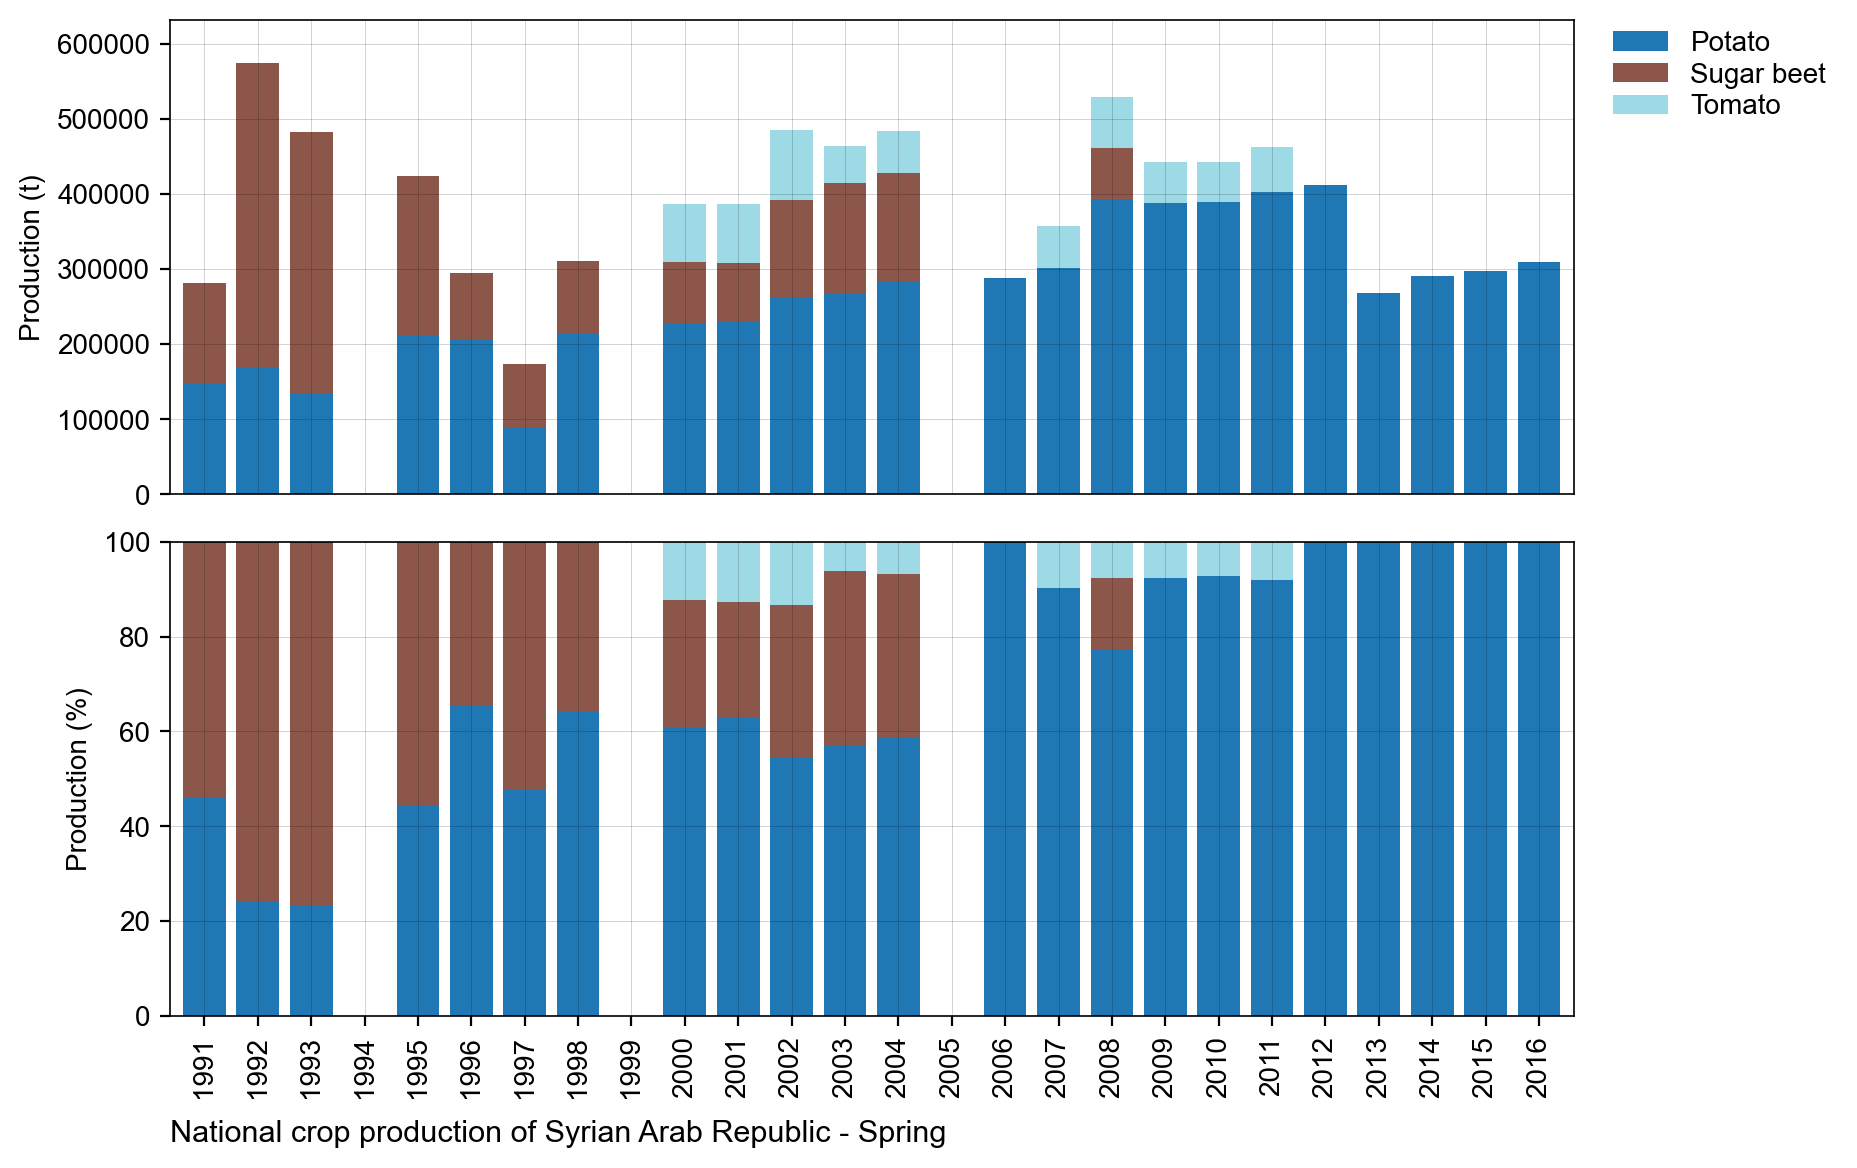

../figures/SY_bar_natgrainprod_Spring.png is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


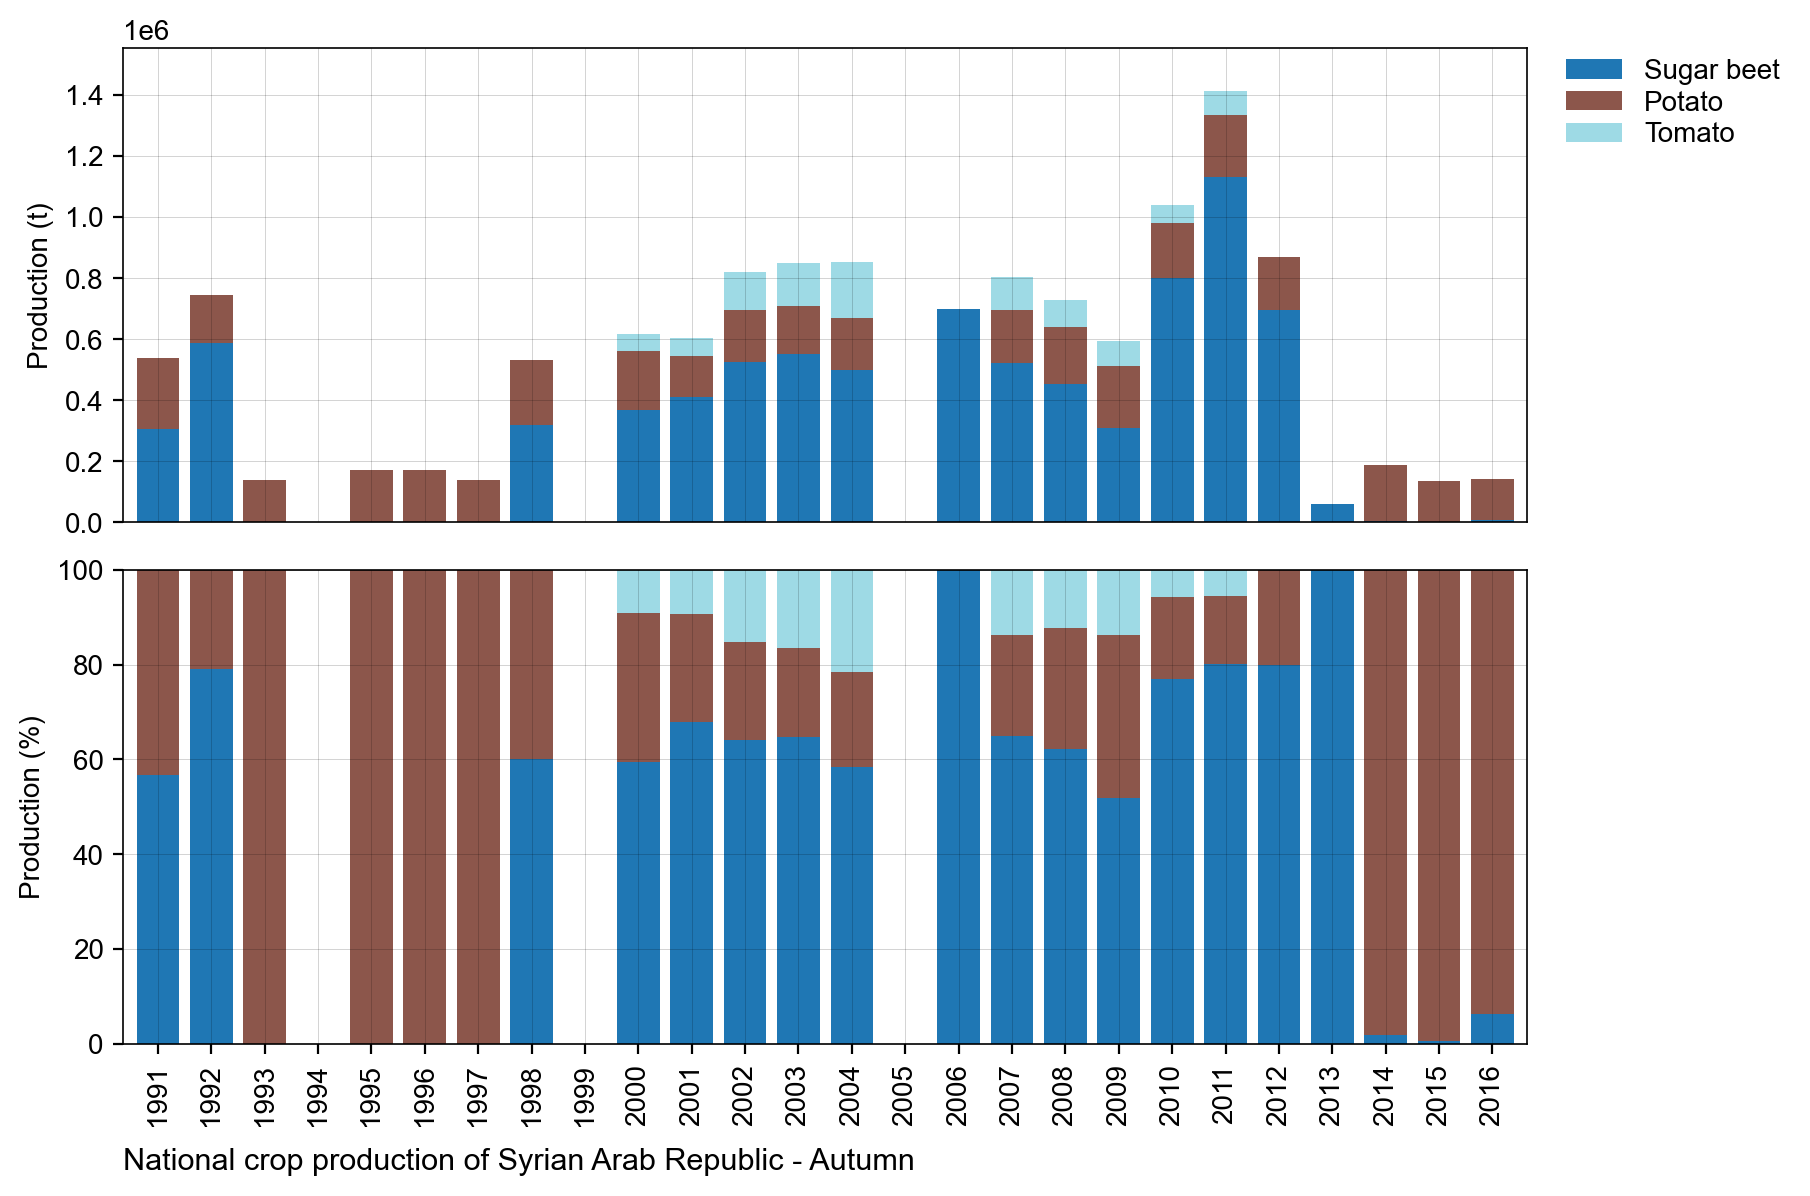

../figures/SY_bar_natgrainprod_Autumn.png is saved.


E:\upload _gscd\gscd\notebook\tools_graphic.py:135: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


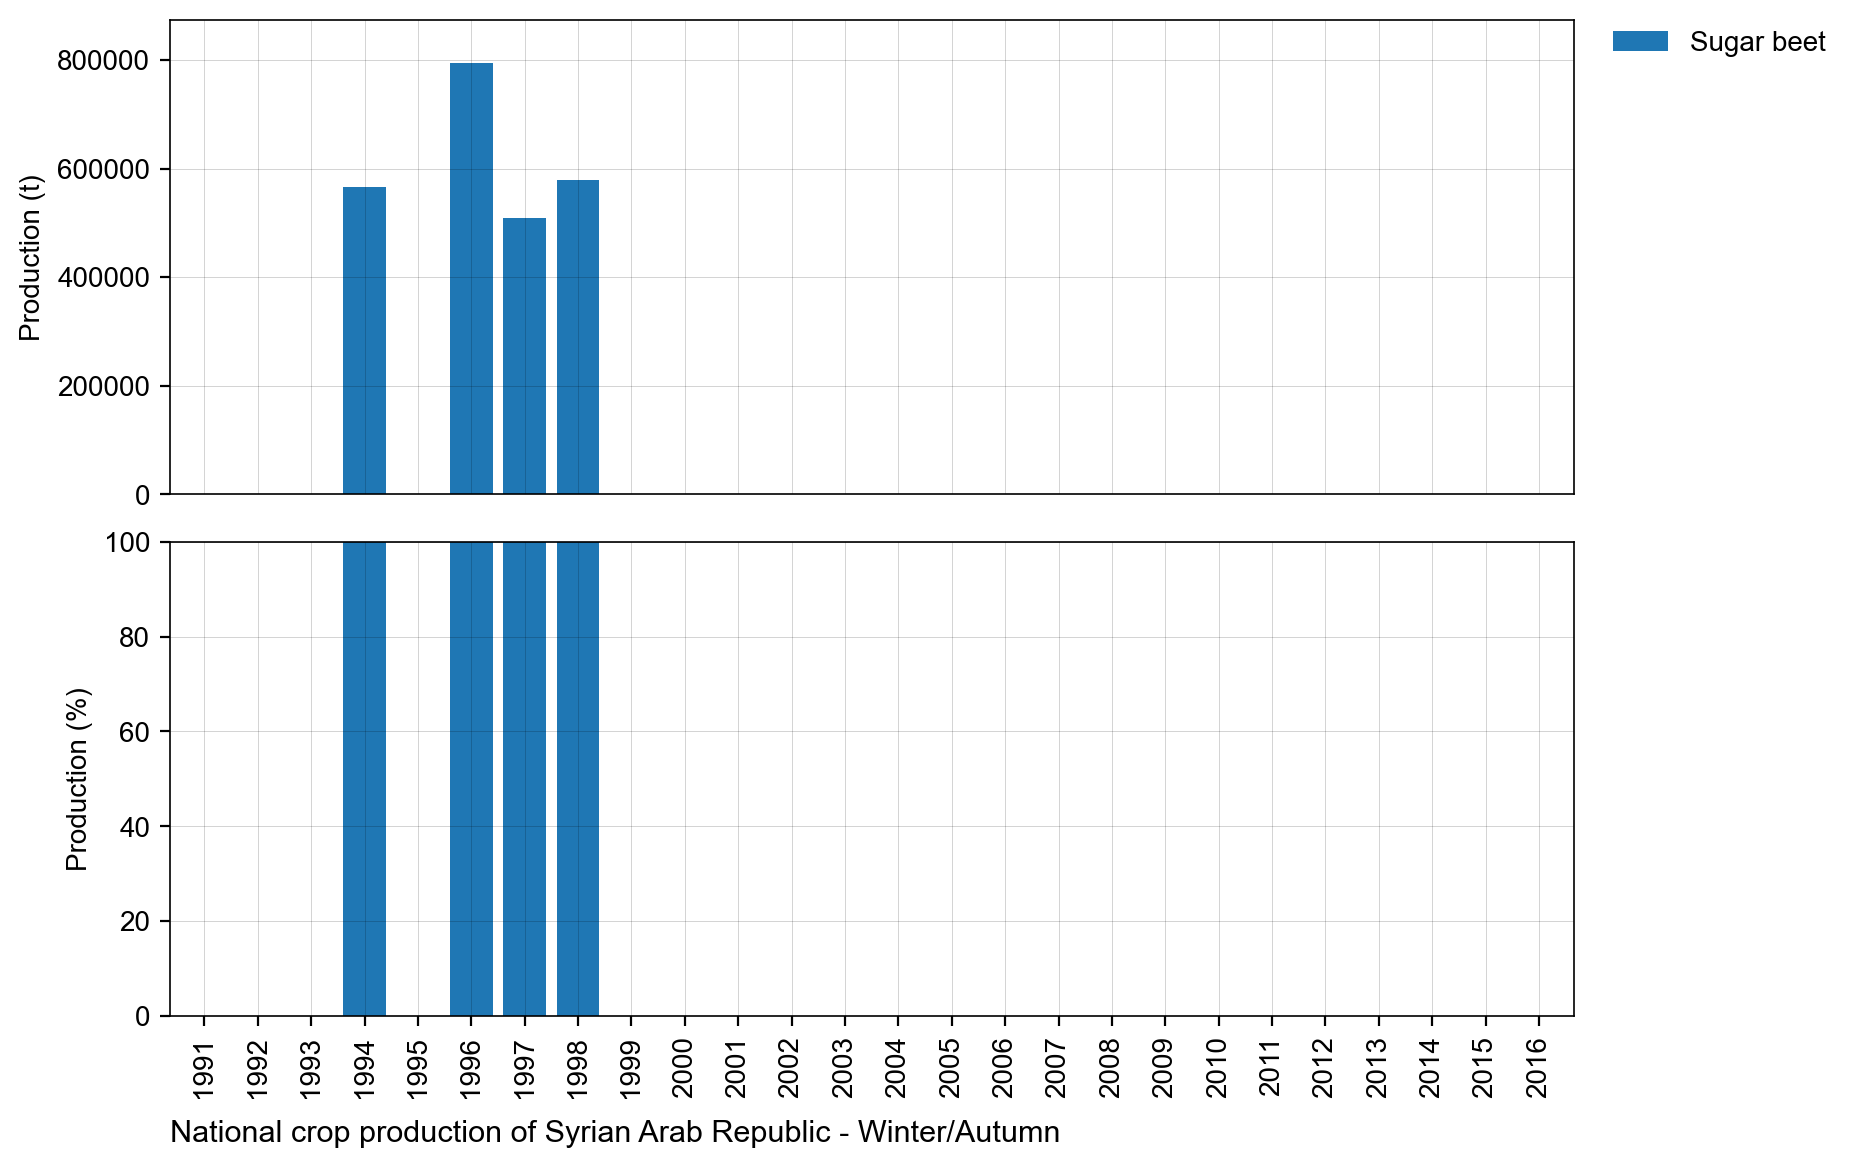

FileNotFoundError: [Errno 2] No such file or directory: '../figures/SY_bar_natgrainprod_Winter/Autumn.png'

In [38]:
# Bar chart of national grain production
country_iso, country_name = 'SY', 'Syrian Arab Republic'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual','Winter','Summer','Spring','Autumn','Winter/Autumn']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    if len(sub)<5:
        continue
    PlotBarProduction(sub, year, footnote, fn_save)

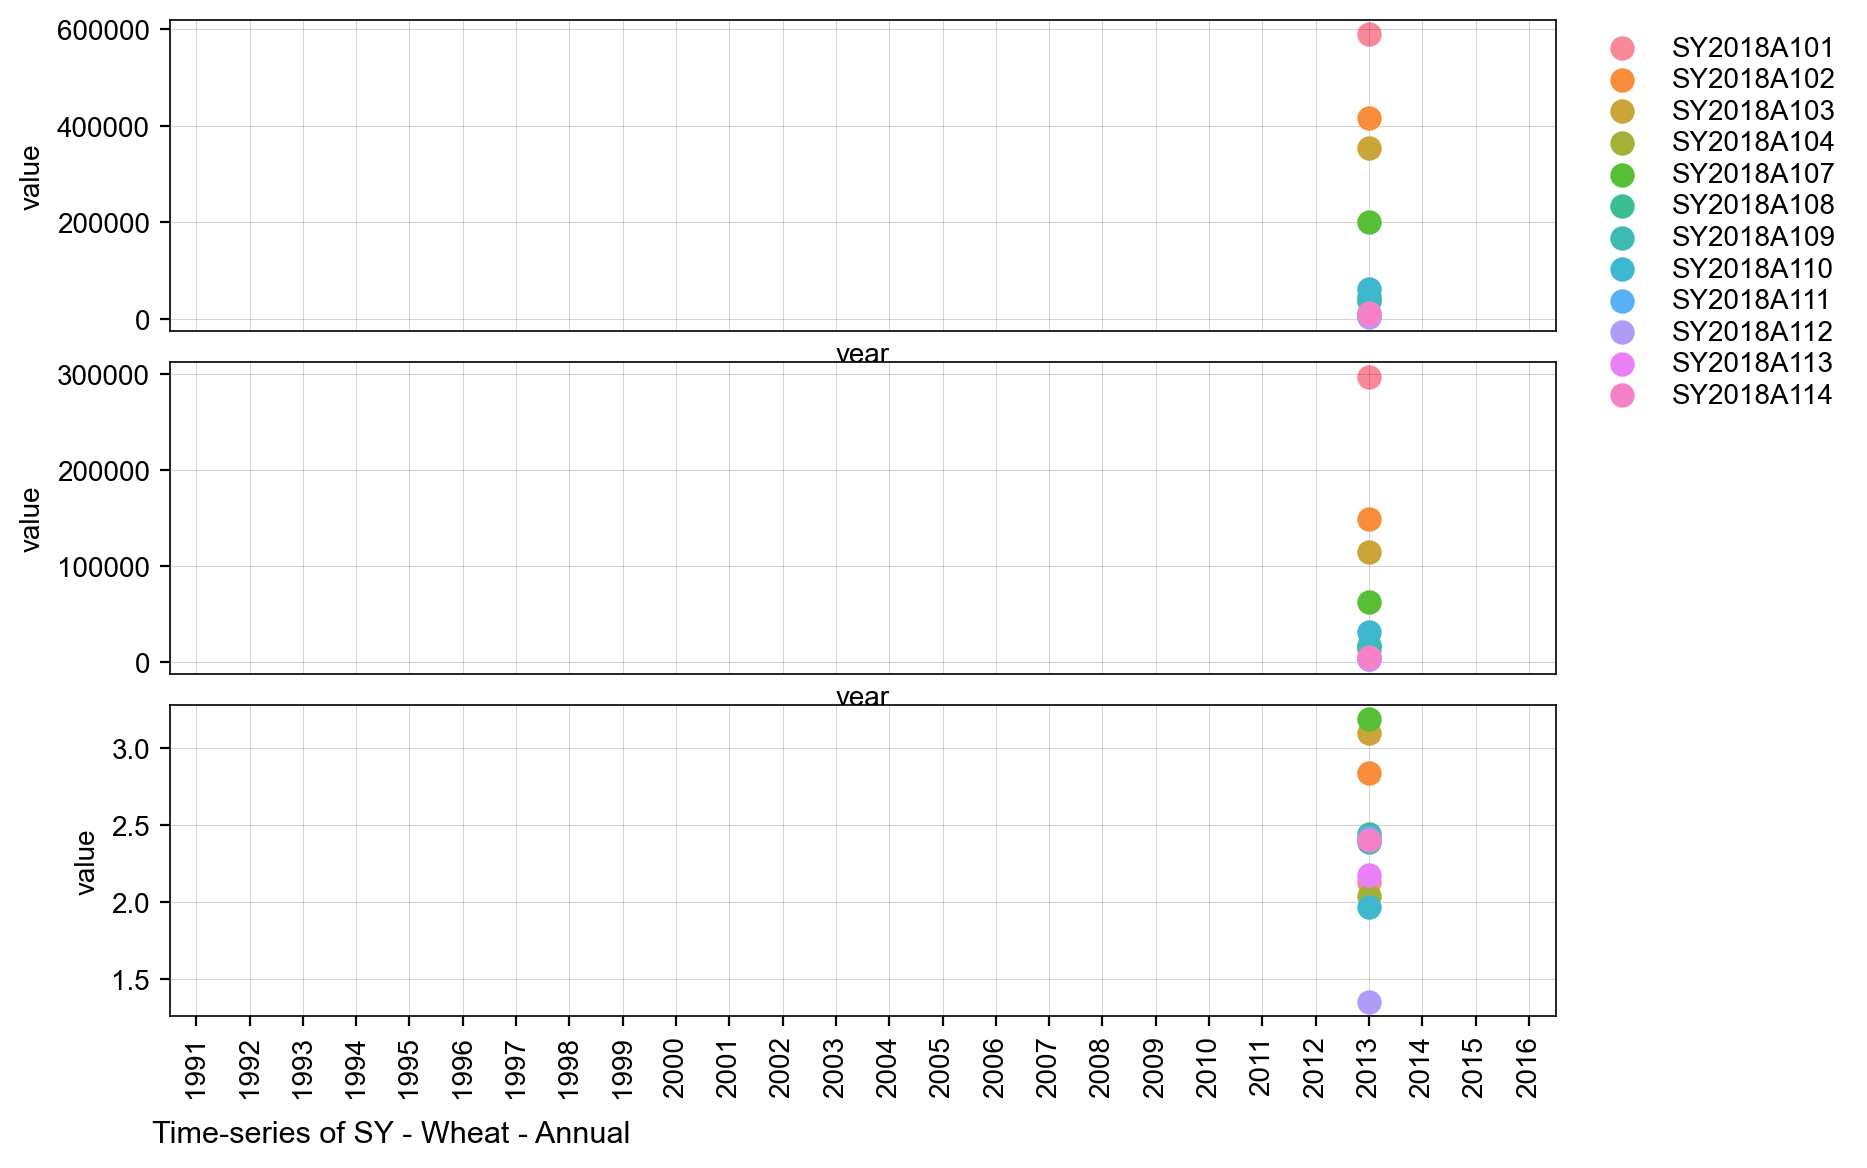

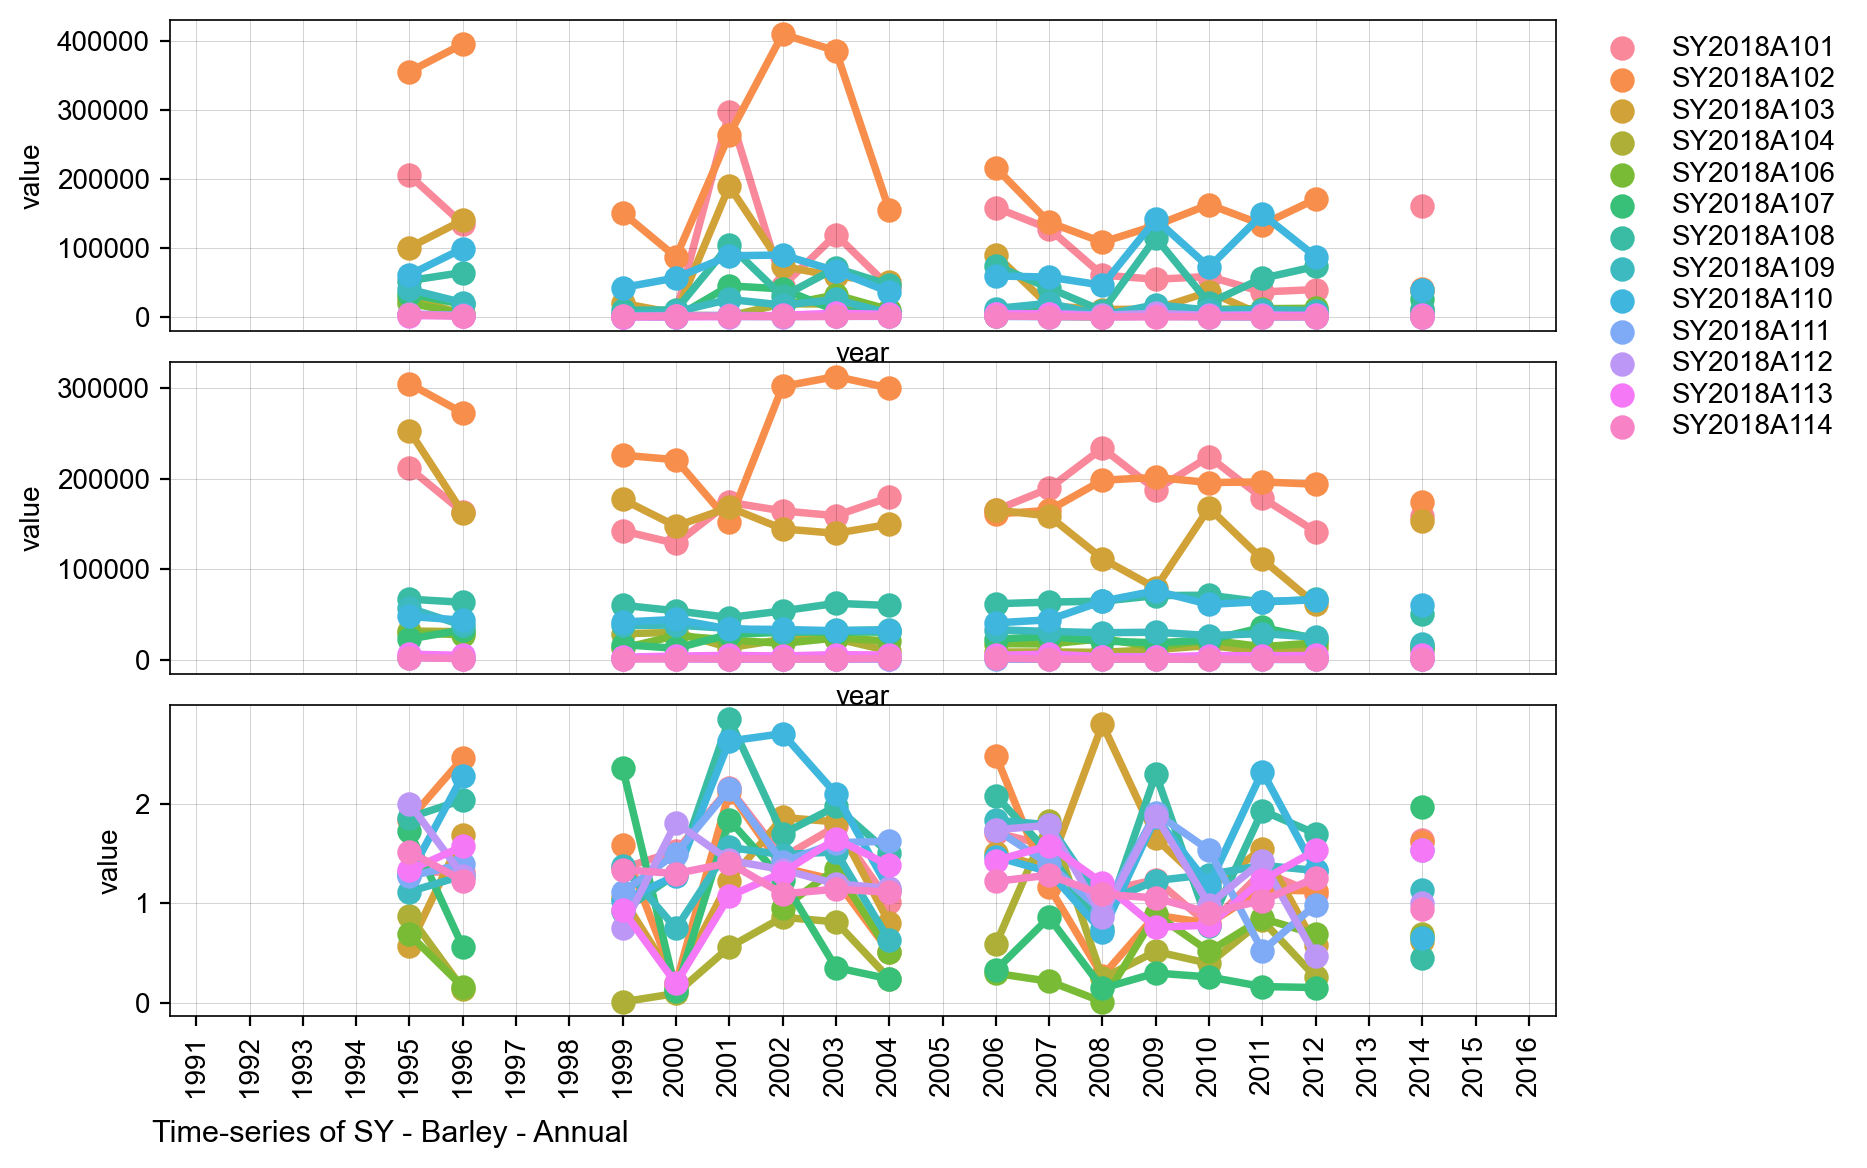

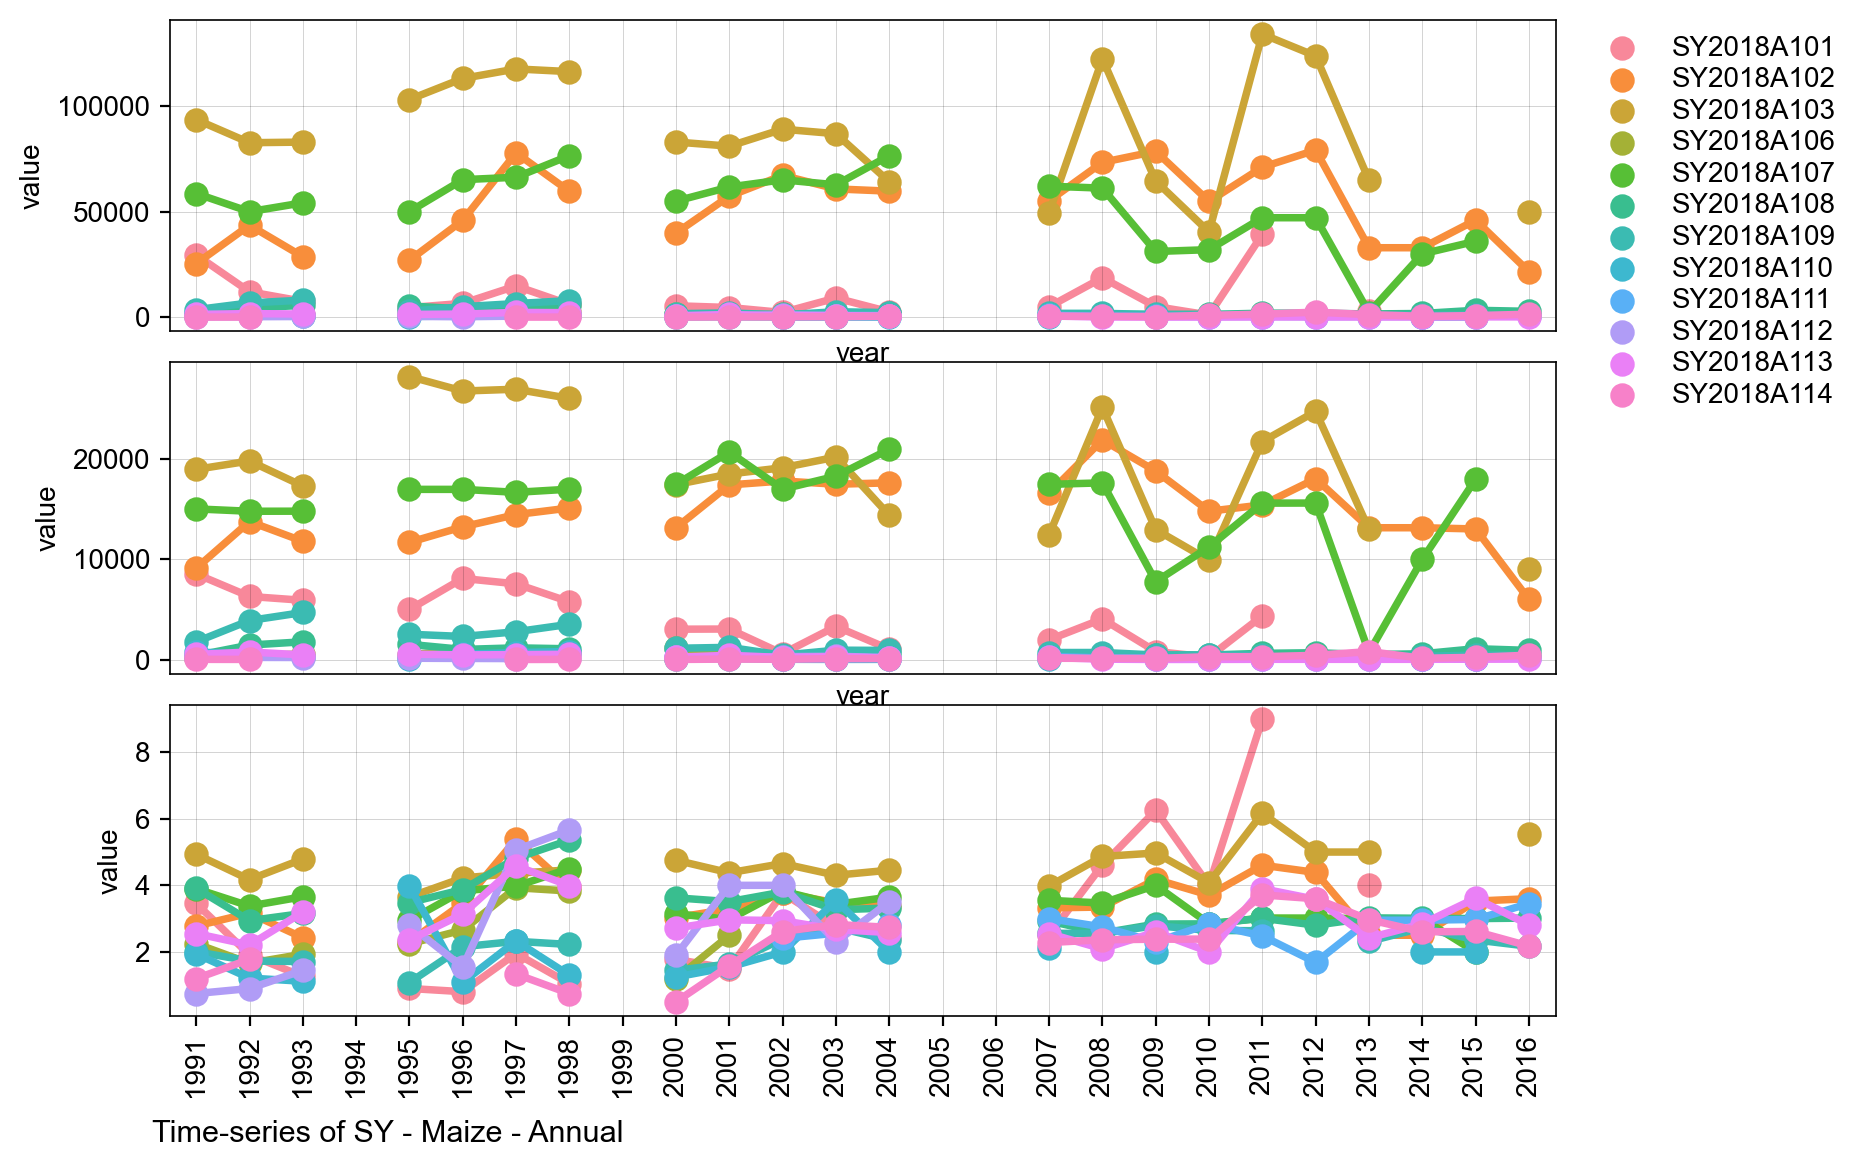

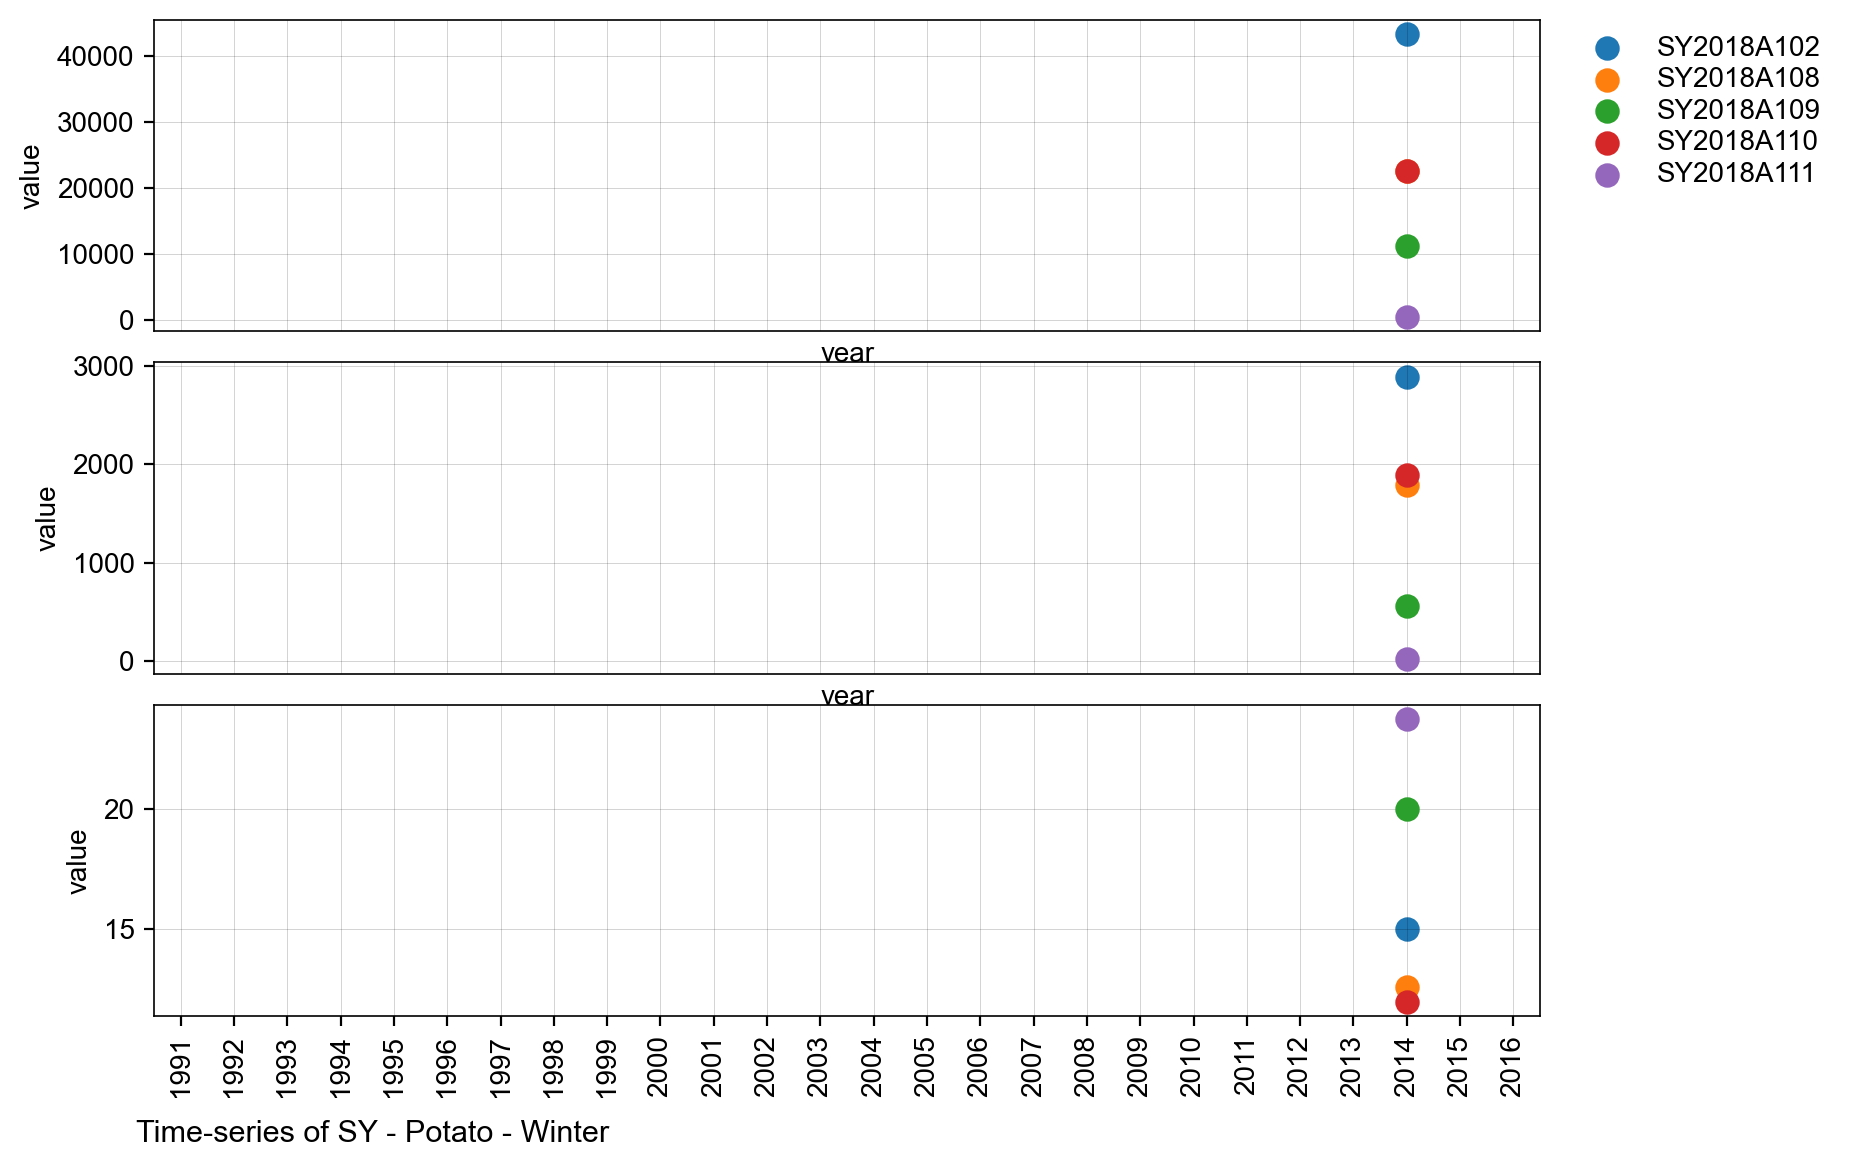

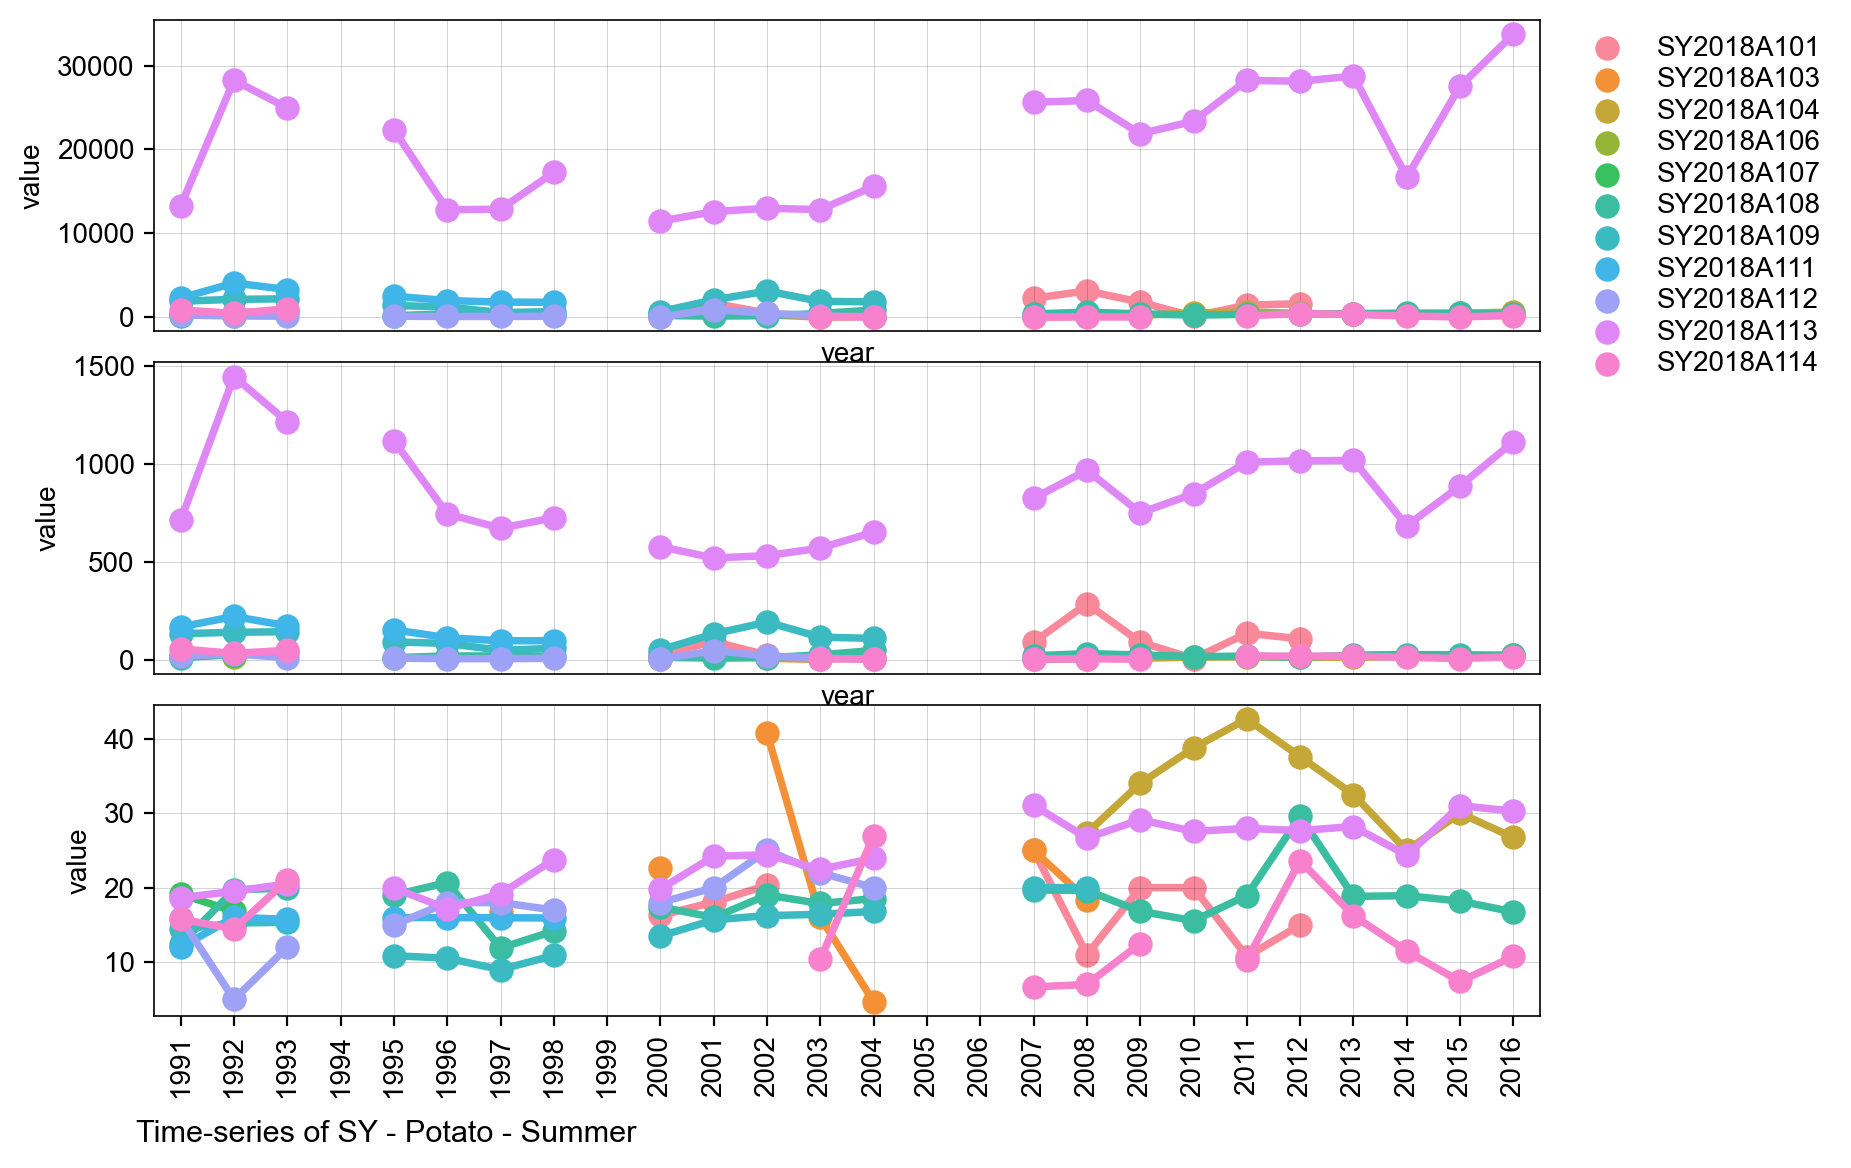

In [40]:
# Lineplot of Production-Area-Yield (PAY) time-series
country_iso, country_name = 'SY', 'Syrian Arab Republic'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
# df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Wheat','Annual'],
    ['Barley','Annual'],
    ['Maize','Annual'],
    ['Potato','Winter'],
    ['Potato','Summer']
    
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)